# CIDS-Sim Ensemble with Non-IID data

Ensemble averaging involves collaboration among multiple clients to learn from decentralized data. In the context of CIDS, each client acts as a detector unit distributed across various networks, while a central server functions as the correlation unit by aggregating predictions from the ensemble of models. This research employs a non-IID (Non-Independent and Identically Distributed) data setting to distribute diverse data across different clients. Ensemble averaging is used to combine the predictions from multiple clients, enhancing the robustness and accuracy of the overall intrusion detection system.

## Dataset

This simulator will use a Coordinated Attack dataset with [NetFlow (NF) features](https://drive.google.com/file/d/1xioZGRQKYbrpiBhkd56sHxFtdn4rEiTt/view).  For the NF dataset, please download from [here](https://www.kaggle.com/luminardata).

## Other Information

The simulator will run binary classification, so the traffic will labeled as normal (0) or anomaly (1)

---

First, import libraries

---

In [1]:
import numpy as np
import pandas as pd
import time
import psutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Recall, Precision

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

2024-11-28 14:46:45.855984: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 14:46:45.859619: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 14:46:45.869897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 14:46:45.885847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 14:46:45.890719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 14:46:45.903537: I tensorflow/core/platform/cpu_feature_gu

---

Load Coordinated Attack dataset. We are using ".parquet" file for faster reading data.

Use `CoAt_NF-UQ-NIDS-V2.parquet` for a dataset with the NF feature for the Non-IID scenario.

---

In [2]:
# Use this to read dataset using parquet file (default)
df = pd.read_parquet('./dataset/CoAt_NF-UQ-NIDS-V2.parquet', engine='pyarrow')

---

View the dataset information

---

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

---

Choose a binary label, so we drop the multi-class label

---

In [4]:
df = df.drop(columns=['Label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

---

View normal (0) and anomaly (1) traffic distribution

---

In [5]:
df['Attack'].value_counts()

Attack
1    22892774
0    20743823
Name: count, dtype: int64

---

X and y are used to represent the input features and the corresponding target labels, respectively.

---

In [6]:
X_df = df.drop(columns=['Attack'])
y_df = df['Attack']

---

Scaling data to ensures that features have values in the same range

---

In [7]:
# Use this scaler for NF dataset
scaler = QuantileTransformer(output_distribution='normal')

In [8]:
X_df_scl = scaler.fit_transform(X_df)

---

This Python function, `load_data(client_id)`, is designed to load a portion of data for a specific client in a Federated Learning setting where non-IID data is distributed among different clients. That process is designed to divide a large dataset into smaller portions for different clients.

Please change `fraction` variable if you want to change the data portion that will distribute to each client.

---

In [9]:
def load_data(client_id):
    
    # Create non-IID splits based on client_id
    np.random.seed(client_id)
    indices = np.arange(len(X_df_scl))
    np.random.shuffle(indices)

    # Choose a fraction of the data for this client
    fraction = 0.2
    client_data_size = int(fraction * len(X_df_scl))
    client_indices = indices[:client_data_size]

    X_client = X_df_scl[client_indices]
    y_client = y_df.iloc[client_indices]

    return X_client, y_client

---

The `create_model()` function defines a simple deep neural network model using Keras.
You can change the **number of neurons** in each **Dense layer**.
You can also experiment by changing the **Activation function, Loss function, and optimizer** from the deep learning model.

---

In [10]:
# Define a simple deep neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=(input_shape,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(3, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy', Recall(), Precision()])
    return model

---

Calculate model size to measure the overhead in communication

---

In [11]:
def calculate_model_size(model):
    """Calculates the size of the model in bytes."""
    total_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    return total_params * 4  # 4 bytes per float32 parameter

In [12]:
def calculate_f1_score(precision, recall):
    if (precision + recall) == 0:
        return 0  # To avoid division by zero
    return 2 * (precision * recall) / (precision + recall)

---

The `cids_ensemble_training()` function implements the **training process for a Collaborative Intrusion Detection System (CIDS) using Ensemble Learning**. The goal is to train a global model based on the local training of models across multiple distributed nodes, without sharing raw data. 

This function performs ensemble learning for intrusion detection across `num_nodes` (clients or devices) over `num_rounds` (iterations of ensemble learning). You can experiment by changing `num_nodes` and `num_rounds` from this function.

---

In [13]:
# CIDS with ensemble learning training process

# change num_nodes and num_rounds for your simulation scenario

def cids_ensemble_training(num_nodes=5, num_rounds=5): 
    ensemble_models = []  # Array to store each model in the ensemble
    model_sizes = []  # List to store model sizes for each model in the ensemble

    global_pred_times = []

    communication_overhead = 0

    #Global model performance evaluation
    global_accuracies = []
    global_precisions = []
    global_recalls = []
    global_f1s = []

    # Variable for global training and prediction time
    total_training_times = []
    total_prediction_times = []

    # Variable for global training CPU and Memory usage
    cpu_usages = []
    memory_usages = []

    # Variable for global variance in performance across nodes
    accuracy_variances = []
    precision_variances = []
    recall_variances = []
    f1_variances = []

    # Variable for global standard deviation of performance
    accuracy_stds = []
    precision_stds = []
    recall_stds = []
    f1_stds = []

    # Initial evaluation
    X_test, Y_test = load_data(num_nodes+1)

    # Training rounds
    for round in range(num_rounds):
        local_training_times = []
        local_prediction_times = []

        #Local model performance evaluation
        local_accuracies = []
        local_precisions = []
        local_recalls = []
        local_f1s = []

        # Local CPU and Memory usage
        round_cpu_usage = []
        round_memory_usage = []

        print(f"\n------------------------------------------------------------\n")
        print(f"Training Round {round + 1}\n")

        for node in range(num_nodes):
            X, Y = load_data(node)
                    
            X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
            
            input_shape = X_train.shape[1]

            model = create_model(input_shape=input_shape)

            # Measure CPU and memory utilization during training
            cpu_before = psutil.cpu_percent(interval=None)
            memory_before = psutil.virtual_memory().percent

            # Measure local training time
            start_train_time = time.time()
            #local training time
            model.fit(X_train, Y_train, epochs=10, batch_size=1000, verbose=0)
            end_train_time = time.time()

            cpu_after = psutil.cpu_percent(interval=None)
            memory_after = psutil.virtual_memory().percent

            local_training_time = end_train_time - start_train_time
            local_training_times.append(local_training_time)

            cpu_usage = cpu_after - cpu_before
            memory_usage = memory_after - memory_before

            print(f"Node {node + 1}: Training Time {local_training_time:.4f} seconds")
            print(f"Node {node + 1}: CPU Usage {cpu_usage:.2f}% - Memory Usage {memory_usage:.2f}%")

            # Measure local resource consumption
            round_cpu_usage.append(cpu_usage)
            round_memory_usage.append(memory_usage)

            # Measure local prediction time
            start_pred_time = time.time()
            # Validation
            loss, accuracy, precision, recall = model.evaluate(X_val, Y_val, verbose=0)
            end_pred_time = time.time()

            local_prediction_time = end_pred_time - start_pred_time
            local_prediction_times.append(local_prediction_time)

            print(f"Node {node + 1}: Prediction Time {local_prediction_time:.4f} seconds")
            
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
            print(f"Node {node + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

            #Append local performance data
            local_accuracies.append(accuracy)
            local_precisions.append(precision)
            local_recalls.append(recall)
            local_f1s.append(f1_score)

            ensemble_models.append(model)

            # Calculate and accumulate communication overhead
            model_size = calculate_model_size(model)
            model_sizes.append(model_size)  # Store model size
            communication_overhead += model_size  # Size of model sent to the server

        # Measure global prediction time
        start_glob_pred_time = time.time()
        
        # Ensemble prediction on global test data after each round
        ensemble_predictions = []
        for model in ensemble_models:
            predictions = model.predict(X_test, verbose=0)
            ensemble_predictions.append(predictions)

        # Calculate ensemble average prediction
        ensemble_avg_predictions = np.mean(np.array(ensemble_predictions), axis=0)
        ensemble_class_predictions = (ensemble_avg_predictions > 0.5).astype(int)  # Thresholding for binary classification

        # Measure global prediction time
        end_glob_pred_time = time.time()

        global_pred_time = end_glob_pred_time - start_glob_pred_time
        global_pred_times.append(global_pred_time)

        print(f"\nGlobal Prediction Time Round {round + 1}: {global_pred_time:.4f}")

        # Calculate performance metrics for the ensemble model
        accuracy = accuracy_score(Y_test, ensemble_class_predictions)
        precision = precision_score(Y_test, ensemble_class_predictions, average='binary')
        recall = recall_score(Y_test, ensemble_class_predictions, average='binary')
        f1 = calculate_f1_score(precision, recall)

        global_accuracies.append(accuracy)
        global_precisions.append(precision)
        global_recalls.append(recall)
        global_f1s.append(f1)
        
        print(f"\nRound {round + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

        # Cross-node Generalization Calculation
        accuracy_variance = np.var(local_accuracies)
        accuracy_variances.append(accuracy_variance)
        precision_variance = np.var(local_precisions)
        precision_variances.append(precision_variance)
        recall_variance = np.var(local_recalls)
        recall_variances.append(recall_variance)
        f1_variance = np.var(local_f1s)
        f1_variances.append(f1_variance)

        accuracy_std = np.std(local_accuracies)
        accuracy_stds.append(accuracy_std)
        precision_std = np.std(local_precisions)
        precision_stds.append(precision_std)
        recall_std = np.std(local_recalls)
        recall_stds.append(recall_std)
        f1_std = np.std(local_f1s)
        f1_stds.append(f1_std)

        print(f"Cross-node Generalization after Round {round + 1}:")
        print(f"Accuracy Variance: {accuracy_variance:.4f}, Accuracy Std: {accuracy_std:.4f}")
        print(f"Precision Variance: {precision_variance:.4f}, Precision Std: {precision_std:.4f}")
        print(f"Recall Variance: {recall_variance:.4f}, Recall Std: {recall_std:.4f}")
        print(f"F1-Score Variance: {f1_variance:.4f}, F1-Score Std: {f1_std:.4f}\n")

        # Communication: Server sending updated weights to all nodes
        communication_overhead += num_nodes * sum(model_sizes)

        print(f"Total communication overhead after round {round + 1}: {communication_overhead / 1e6:.2f} MB")

        # Calculate total training time for the round
        total_training_time = sum(local_training_times)
        total_training_times.append(total_training_time)

        print(f"\nTotal Training Time Round {round + 1}: {total_training_time:.4f}")

        # Calculate total prediction time for the round
        total_prediction_time = sum(local_prediction_times)
        total_prediction_times.append(total_prediction_time)

        print(f"\nTotal Prediction Time Round {round + 1}: {total_prediction_time:.4f}")

        # Append round-level resource utilization
        cpu_usages.append(np.mean(round_cpu_usage))
        memory_usages.append(np.mean(round_memory_usage))

    return ensemble_models, global_accuracies, global_precisions, global_recalls, global_f1s, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds

---

Run the simulation, then get the global model and perfromance metric in each round.

---

In [14]:
# Run CIDS simulator with Non-IID data from single dataset
print("Simulation for CIDS with Non-IID Data\n")
ens_model, ens_global_accuracies, ens_global_precisions, ens_global_recalls, ens_global_f1s, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds = cids_ensemble_training()

Simulation for CIDS with Non-IID Data


------------------------------------------------------------

Training Round 1



/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Node 1: Training Time 72.2772 seconds
Node 1: CPU Usage 3.30% - Memory Usage 0.30%
Node 1: Prediction Time 31.0167 seconds
Node 1: Accuracy 0.9738 - Precision 0.9742 - Recall 0.9758 - F1-Score 0.9750

Node 2: Training Time 72.9462 seconds
Node 2: CPU Usage 1.40% - Memory Usage -0.30%
Node 2: Prediction Time 33.0576 seconds
Node 2: Accuracy 0.9735 - Precision 0.9832 - Recall 0.9668 - F1-Score 0.9749

Node 3: Training Time 73.1315 seconds
Node 3: CPU Usage 1.70% - Memory Usage -0.30%
Node 3: Prediction Time 32.3288 seconds
Node 3: Accuracy 0.9699 - Precision 0.9834 - Recall 0.9602 - F1-Score 0.9717

Node 4: Training Time 73.4603 seconds
Node 4: CPU Usage 1.90% - Memory Usage -0.40%
Node 4: Prediction Time 32.7513 seconds
Node 4: Accuracy 0.9739 - Precision 0.9697 - Recall 0.9803 - F1-Score 0.9750

Node 5: Training Time 72.6327 seconds
Node 5: CPU Usage 1.60% - Memory Usage -0.30%
Node 5: Prediction Time 31.5584 seconds
Node 5: Accuracy 0.9739 - Precision 0.9719 - Recall 0.9783 - F1-Score

/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Node 1: Training Time 77.4529 seconds
Node 1: CPU Usage 2.70% - Memory Usage -0.80%
Node 1: Prediction Time 35.0651 seconds
Node 1: Accuracy 0.9744 - Precision 0.9671 - Recall 0.9838 - F1-Score 0.9754

Node 2: Training Time 76.3295 seconds
Node 2: CPU Usage 2.00% - Memory Usage -0.50%
Node 2: Prediction Time 33.6065 seconds
Node 2: Accuracy 0.9706 - Precision 0.9666 - Recall 0.9770 - F1-Score 0.9718

Node 3: Training Time 77.4686 seconds
Node 3: CPU Usage 2.20% - Memory Usage -0.40%
Node 3: Prediction Time 33.9414 seconds
Node 3: Accuracy 0.9716 - Precision 0.9775 - Recall 0.9687 - F1-Score 0.9731

Node 4: Training Time 75.9882 seconds
Node 4: CPU Usage 2.20% - Memory Usage -0.50%
Node 4: Prediction Time 34.5289 seconds
Node 4: Accuracy 0.9730 - Precision 0.9813 - Recall 0.9678 - F1-Score 0.9745

Node 5: Training Time 74.6769 seconds
Node 5: CPU Usage 1.70% - Memory Usage -0.10%
Node 5: Prediction Time 33.7733 seconds
Node 5: Accuracy 0.9247 - Precision 0.9860 - Recall 0.8841 - F1-Scor

/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Node 1: Training Time 73.9312 seconds
Node 1: CPU Usage 2.40% - Memory Usage -0.90%
Node 1: Prediction Time 32.5757 seconds
Node 1: Accuracy 0.9707 - Precision 0.9840 - Recall 0.9610 - F1-Score 0.9724

Node 2: Training Time 74.1326 seconds
Node 2: CPU Usage 1.90% - Memory Usage -0.40%
Node 2: Prediction Time 32.7705 seconds
Node 2: Accuracy 0.9733 - Precision 0.9814 - Recall 0.9681 - F1-Score 0.9747

Node 3: Training Time 73.4457 seconds
Node 3: CPU Usage 1.90% - Memory Usage -0.40%
Node 3: Prediction Time 33.2536 seconds
Node 3: Accuracy 0.9749 - Precision 0.9801 - Recall 0.9722 - F1-Score 0.9762

Node 4: Training Time 73.7771 seconds
Node 4: CPU Usage 1.80% - Memory Usage -0.10%
Node 4: Prediction Time 32.4419 seconds
Node 4: Accuracy 0.9737 - Precision 0.9826 - Recall 0.9678 - F1-Score 0.9752

Node 5: Training Time 74.4748 seconds
Node 5: CPU Usage 1.90% - Memory Usage -0.50%
Node 5: Prediction Time 32.3787 seconds
Node 5: Accuracy 0.9724 - Precision 0.9836 - Recall 0.9646 - F1-Scor

/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Node 1: Training Time 77.0730 seconds
Node 1: CPU Usage 2.80% - Memory Usage -0.80%
Node 1: Prediction Time 34.9232 seconds
Node 1: Accuracy 0.9699 - Precision 0.9784 - Recall 0.9648 - F1-Score 0.9715

Node 2: Training Time 78.0616 seconds
Node 2: CPU Usage 2.10% - Memory Usage -0.60%
Node 2: Prediction Time 32.5757 seconds
Node 2: Accuracy 0.9738 - Precision 0.9816 - Recall 0.9688 - F1-Score 0.9752

Node 3: Training Time 76.6557 seconds
Node 3: CPU Usage 2.10% - Memory Usage -0.30%
Node 3: Prediction Time 34.1367 seconds
Node 3: Accuracy 0.9735 - Precision 0.9817 - Recall 0.9683 - F1-Score 0.9750

Node 4: Training Time 79.6802 seconds
Node 4: CPU Usage 2.20% - Memory Usage -0.50%
Node 4: Prediction Time 34.5015 seconds
Node 4: Accuracy 0.9734 - Precision 0.9789 - Recall 0.9708 - F1-Score 0.9748

Node 5: Training Time 78.4608 seconds
Node 5: CPU Usage 2.00% - Memory Usage -0.50%
Node 5: Prediction Time 35.1645 seconds
Node 5: Accuracy 0.9736 - Precision 0.9828 - Recall 0.9675 - F1-Scor

/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Node 1: Training Time 72.9867 seconds
Node 1: CPU Usage 2.30% - Memory Usage -1.10%
Node 1: Prediction Time 32.7398 seconds
Node 1: Accuracy 0.9736 - Precision 0.9817 - Recall 0.9685 - F1-Score 0.9751

Node 2: Training Time 73.3905 seconds
Node 2: CPU Usage 1.70% - Memory Usage -0.40%
Node 2: Prediction Time 31.9560 seconds
Node 2: Accuracy 0.9739 - Precision 0.9834 - Recall 0.9674 - F1-Score 0.9753

Node 3: Training Time 73.1140 seconds
Node 3: CPU Usage 1.50% - Memory Usage -0.40%
Node 3: Prediction Time 32.0726 seconds
Node 3: Accuracy 0.9727 - Precision 0.9826 - Recall 0.9660 - F1-Score 0.9742

Node 4: Training Time 73.1231 seconds
Node 4: CPU Usage 1.70% - Memory Usage -0.50%
Node 4: Prediction Time 32.0314 seconds
Node 4: Accuracy 0.9750 - Precision 0.9762 - Recall 0.9763 - F1-Score 0.9762

Node 5: Training Time 73.9691 seconds
Node 5: CPU Usage 1.70% - Memory Usage -0.50%
Node 5: Prediction Time 31.9144 seconds
Node 5: Accuracy 0.9740 - Precision 0.9809 - Recall 0.9700 - F1-Scor

In [15]:
print(f"\nFinal Communication Overhead: {communication_overhead / 1e6:.2f} MB")


Final Communication Overhead: 1.80 MB


---

Plot the performance metric in each round using graph

---

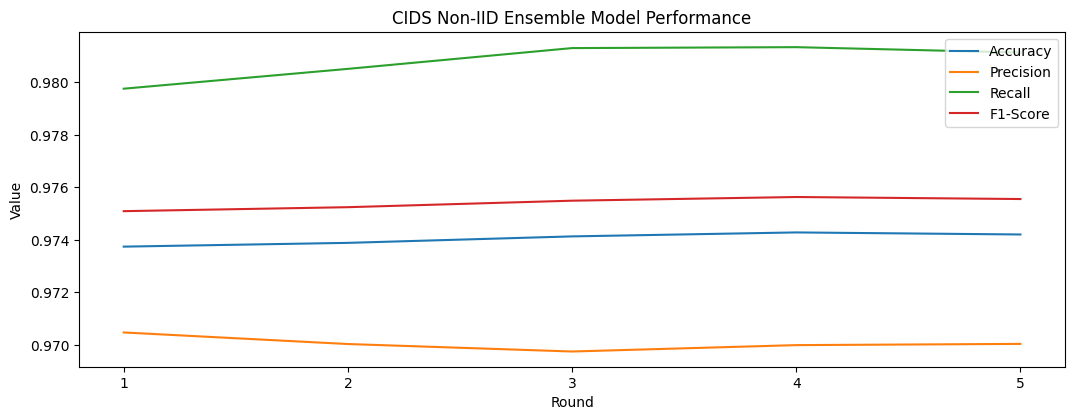

In [16]:
# Plotting model performance results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds1 = np.arange(1, len(ens_global_accuracies) + 1)
plt.plot(rounds1, ens_global_accuracies, label='Accuracy')
plt.plot(rounds1, ens_global_precisions, label='Precision')
plt.plot(rounds1, ens_global_recalls, label='Recall')
plt.plot(rounds1, ens_global_f1s, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID Ensemble Model Performance')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

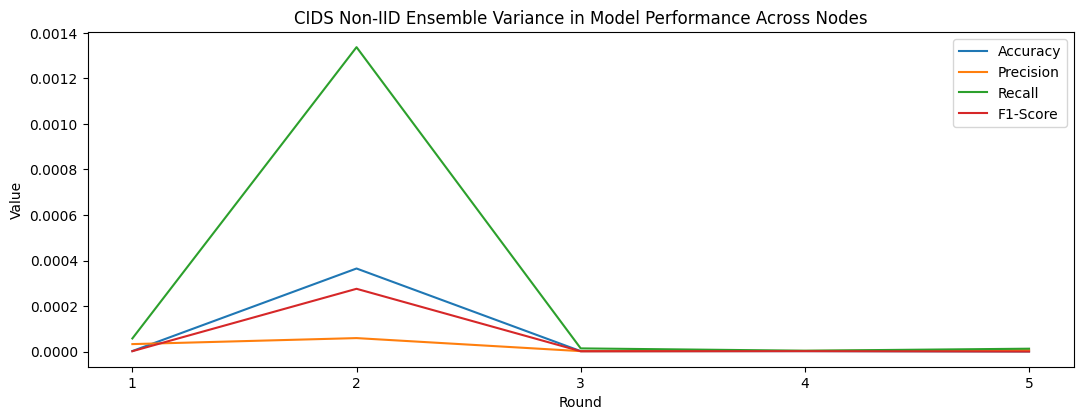

In [17]:
# Plotting model robustness and generalization results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds2 = np.arange(1, len(accuracy_variances) + 1)
plt.plot(rounds2, accuracy_variances, label='Accuracy')
plt.plot(rounds2, precision_variances, label='Precision')
plt.plot(rounds2, recall_variances, label='Recall')
plt.plot(rounds2, f1_variances, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID Ensemble Variance in Model Performance Across Nodes')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

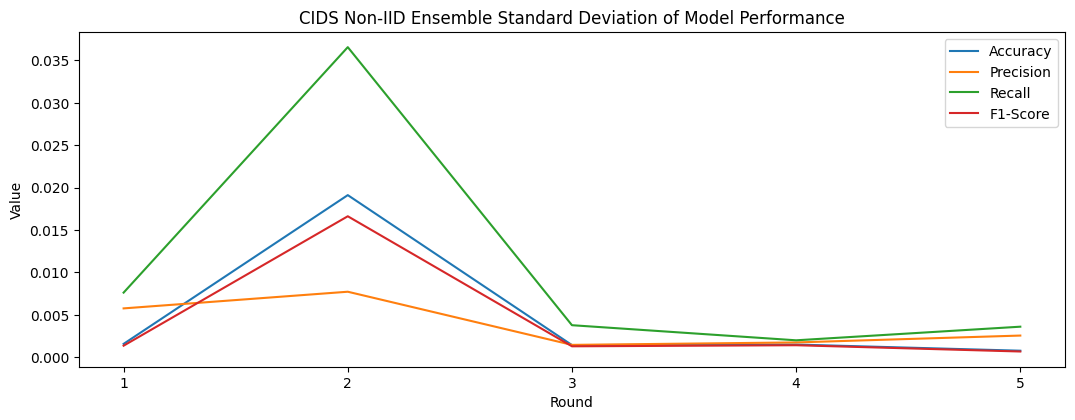

In [18]:
# Plotting model robustness and generalization results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds3 = np.arange(1, len(accuracy_stds) + 1)
plt.plot(rounds3, accuracy_stds, label='Accuracy')
plt.plot(rounds3, precision_stds, label='Precision')
plt.plot(rounds3, recall_stds, label='Recall')
plt.plot(rounds3, f1_stds, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID Ensemble Standard Deviation of Model Performance')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

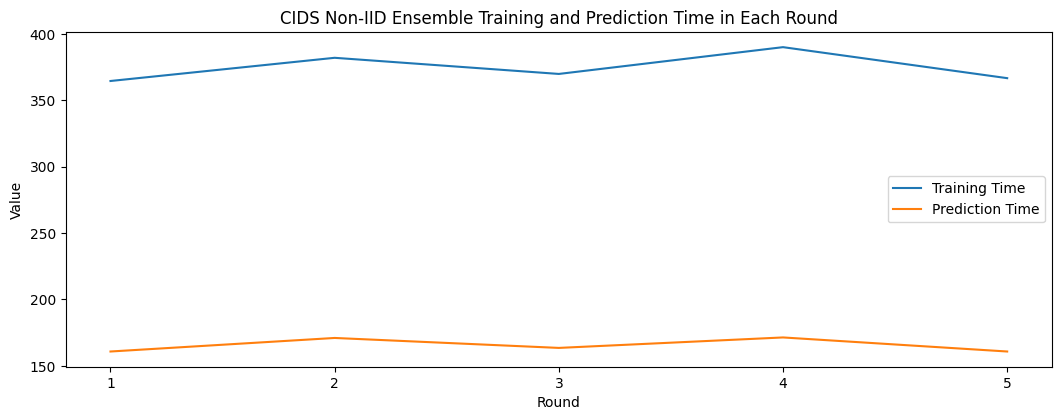

In [19]:
# Plotting training and prediction time
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds4 = np.arange(1, len(total_training_times) + 1)
plt.plot(rounds4, total_training_times, label='Training Time')
plt.plot(rounds4, total_prediction_times, label='Prediction Time')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID Ensemble Training and Prediction Time in Each Round')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

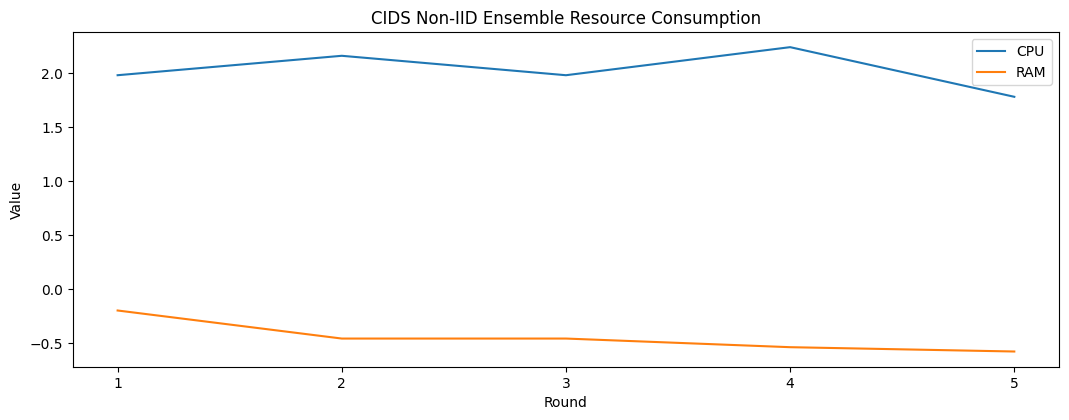

In [20]:
# Plotting resource consumption
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds5 = np.arange(1, len(cpu_usages) + 1)
plt.plot(rounds5, cpu_usages, label='CPU')
plt.plot(rounds5, memory_usages, label='RAM')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID Ensemble Resource Consumption')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

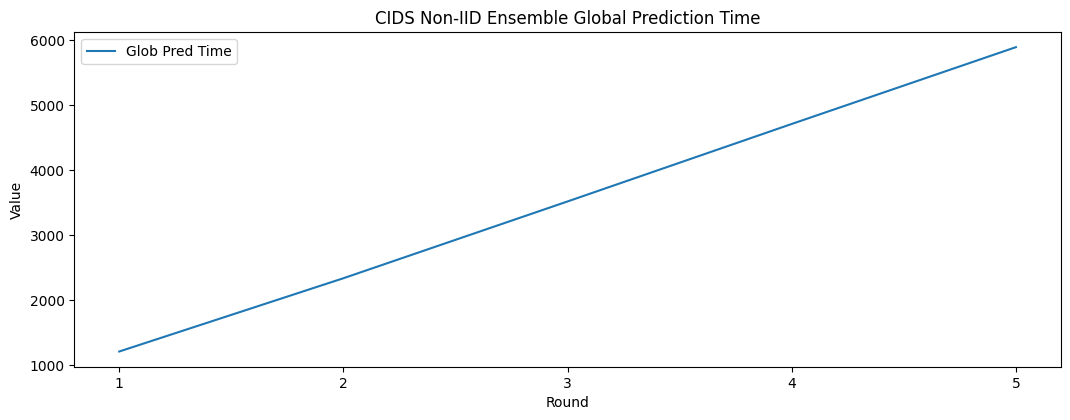

In [21]:
# Plotting global prediction time
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds6 = np.arange(1, len(global_pred_times) + 1)
plt.plot(rounds6, global_pred_times, label='Glob Pred Time')
plt.ylabel('Value')
plt.xlabel('Round')
plt.title('CIDS Non-IID Ensemble Global Prediction Time')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

In [22]:
# Number of rounds
rounds = list(range(1, len(ens_global_accuracies) + 1))

# Save global performance metrics with rounds
global_metrics_df = pd.DataFrame({
    "Round": rounds,
    "Global Accuracy": ens_global_accuracies,
    "Global Precision": ens_global_precisions,
    "Global Recall": ens_global_recalls,
    "Global F1-Score": ens_global_f1s,
    "Global Prediction Time": global_pred_times,
    "Total Training Times": total_training_times,
    "Total Prediction Times": total_prediction_times,
    "CPU Usage": cpu_usages,
    "Memory Usage": memory_usages,
    "Accuracy Variance": accuracy_variances,
    "Precision Variance": precision_variances,
    "Recall Variance": recall_variances,
    "F1 Variance": f1_variances,
    "Accuracy Std": accuracy_stds,
    "Precision Std": precision_stds,
    "Recall Std": recall_stds,
    "F1 Std": f1_stds
})

# Export global metrics to a CSV
global_metrics_df.to_csv("global_performance_metrics_Ensemble_Non-IID_Binary.csv", index=False)

print("All metrics exported to CSV files successfully.")

All metrics exported to CSV files successfully.
